In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

## Grab the test data and visualise

In [2]:
data_path = "/home/sravula/experiments/datasets/8047_vel_imgs.npy"

In [3]:
from datasets.velocity_fine import Velocity

tran_transform = transforms.Compose([
    transforms.Resize([256, 256])
])

dataset = Velocity(path=data_path, transform=tran_transform)

In [4]:
N = len(dataset)
indices = list(range(N))
np.random.seed(2240)
np.random.shuffle(indices)
train_indices, test_indices = indices[:int(N * 0.9)], indices[int(N * 0.9):]

In [5]:
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=False,
                         num_workers=8, drop_last=True)

test_iter = iter(test_loader)

test_sample = next(test_iter)[0]

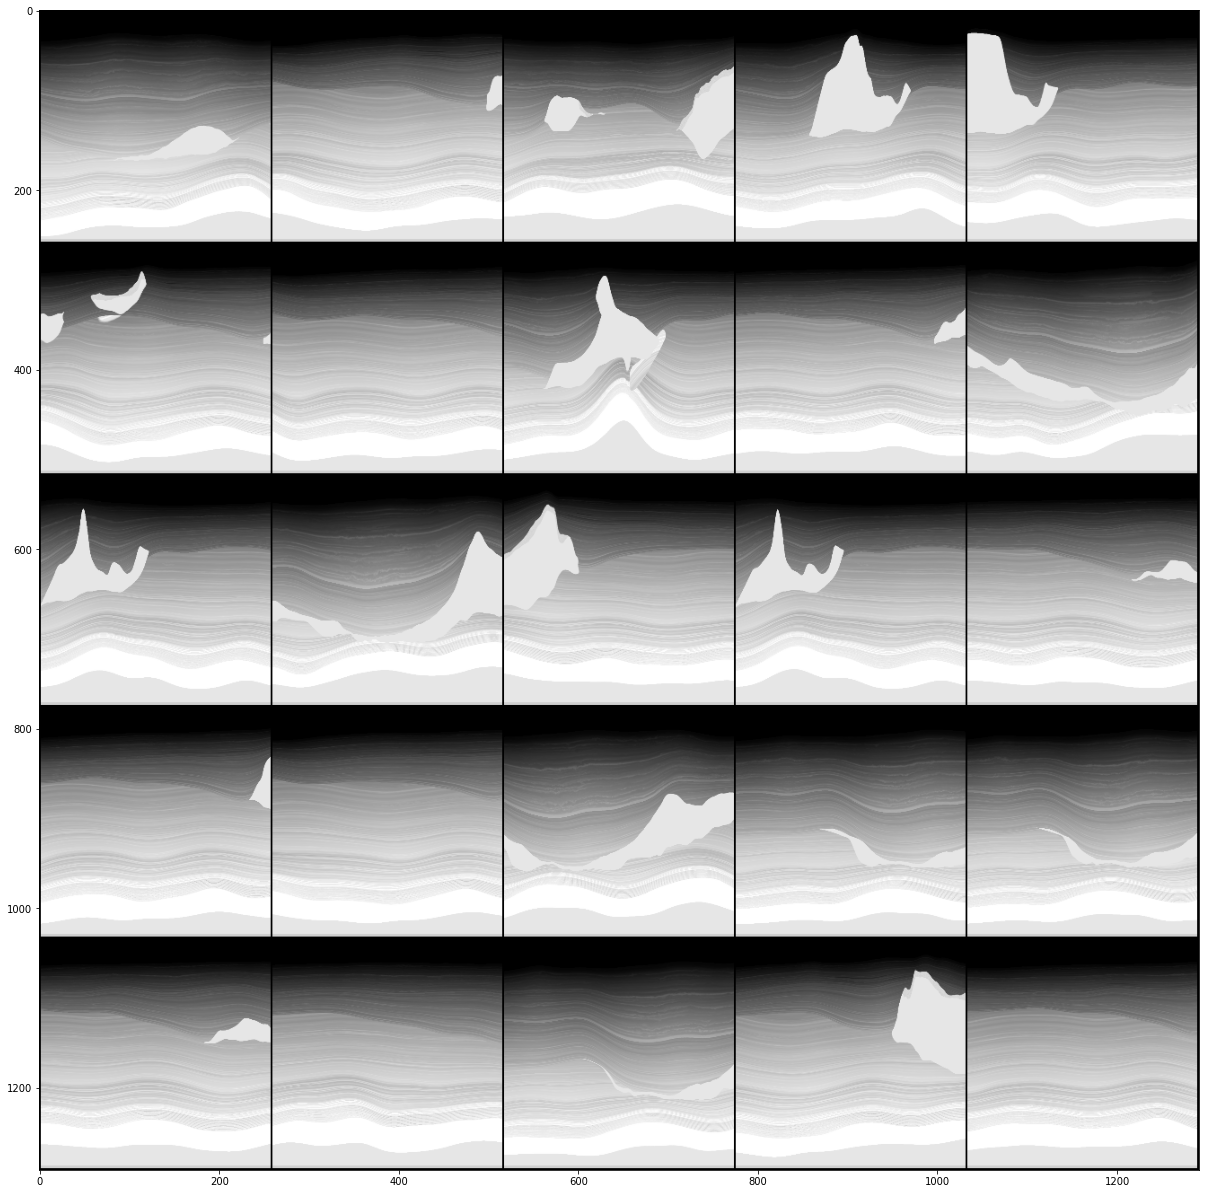

In [7]:
grid_img = torchvision.utils.make_grid(test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Noise the test data and visualise

In [8]:
noisy_test_sample = test_sample + 0.15*torch.randn(test_sample.size())
noisy_test_sample = torch.clip(noisy_test_sample, min=0, max=1)

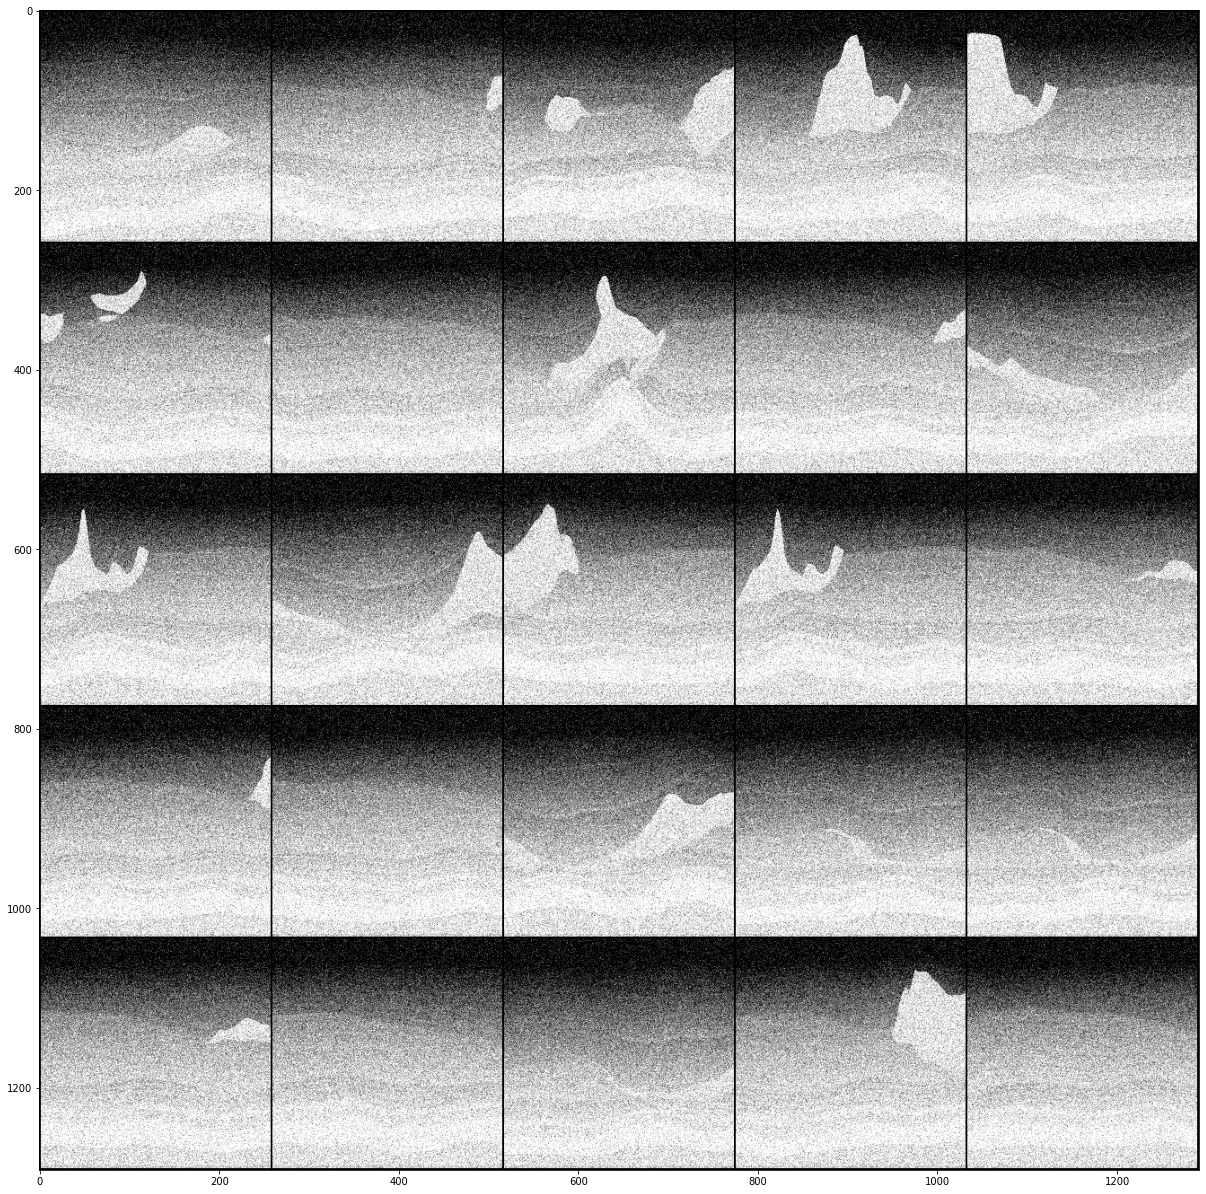

In [9]:
grid_img = torchvision.utils.make_grid(noisy_test_sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Load the network and perform Langevin dynamics on the noisy images

In [10]:
ckpt_path = "/home/sravula/experiments/logs/run_2/checkpoint.pth"
config_path = "/home/sravula/ncsnv2/configs/velocity.yml"

In [11]:
import argparse
from main import dict2namespace
import yaml

with open(config_path, 'r') as f:
    config = yaml.load(f)
new_config = dict2namespace(config)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
new_config.device = device

print(device)

/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


cuda


In [12]:
from models.ncsnv2 import NCSNv2Deepest
from models.ema import EMAHelper
from models import get_sigmas

new_config.input_dim = new_config.data.image_size ** 2 * new_config.data.channels

score = NCSNv2Deepest(new_config).to(new_config.device)
score = torch.nn.DataParallel(score)

#Set up the exponential moving average
if new_config.model.ema:
    ema_helper = EMAHelper(mu=new_config.model.ema_rate)
    ema_helper.register(score)

states = torch.load(ckpt_path)
score.load_state_dict(states[0])
### Make sure we can resume with different eps
states[1]['param_groups'][0]['eps'] = new_config.optim.eps

if new_config.model.ema:
    ema_helper.load_state_dict(states[4])

#grab all L noise levels
sigmas = get_sigmas(new_config)

In [13]:
test_score = ema_helper.ema_copy(score)

test_score.eval()

DataParallel(
  (module): NCSNv2Deepest(
    (act): ELU(alpha=1.0)
    (begin_conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (normalizer): InstanceNorm2dPlus(
      (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (end_conv): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): ModuleList(
      (0): ResidualBlock(
        (non_linearity): ELU(alpha=1.0)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize2): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (normalize1): InstanceNorm2dPlus(
          (instance_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
      )
      (1): Resid

In [14]:
from models import anneal_Langevin_dynamics

noisy_test_sample = noisy_test_sample.to(new_config.device)

all_samples = anneal_Langevin_dynamics(noisy_test_sample, test_score, sigmas.cpu().numpy(),
                                       new_config.sampling.n_steps_each,
                                       new_config.sampling.step_lr,
                                       final_only=True, verbose=True,
                                       denoise=new_config.sampling.denoise)

/home/sravula/venvs/ncsnv2/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


level: 0, step_size: 90.0, grad_norm: 3.3530962467193604, image_norm: 3450.626220703125, snr: 0.08783572167158127, grad_mean_norm: 2607.658935546875
level: 0, step_size: 90.0, grad_norm: 3.41464900970459, image_norm: 4657.79638671875, snr: 0.08940549939870834, grad_mean_norm: 2603.945556640625
level: 0, step_size: 90.0, grad_norm: 3.4137415885925293, image_norm: 5542.66162109375, snr: 0.08948621153831482, grad_mean_norm: 2606.045166015625
level: 1, step_size: 88.5504040406803, grad_norm: 3.4427332878112793, image_norm: 6251.26904296875, snr: 0.08941055089235306, grad_mean_norm: 2617.540771484375
level: 1, step_size: 88.5504040406803, grad_norm: 3.443253755569458, image_norm: 6857.4306640625, snr: 0.08944585919380188, grad_mean_norm: 2628.566162109375
level: 1, step_size: 88.5504040406803, grad_norm: 3.4432342052459717, image_norm: 7383.7255859375, snr: 0.08953686058521271, grad_mean_norm: 2623.088623046875
level: 2, step_size: 87.12415283600005, grad_norm: 3.470459461212158, image_norm

level: 17, step_size: 68.29028605744782, grad_norm: 3.916548728942871, image_norm: 14529.72265625, snr: 0.08939310163259506, grad_mean_norm: 2632.759521484375
level: 17, step_size: 68.29028605744782, grad_norm: 3.9165682792663574, image_norm: 14575.3310546875, snr: 0.08947446197271347, grad_mean_norm: 2627.201416015625
level: 18, step_size: 67.19036074677467, grad_norm: 3.9484856128692627, image_norm: 14611.2080078125, snr: 0.08931896835565567, grad_mean_norm: 2631.63671875
level: 18, step_size: 67.19036074677467, grad_norm: 3.9487431049346924, image_norm: 14650.09765625, snr: 0.08949235081672668, grad_mean_norm: 2628.39599609375
level: 18, step_size: 67.19036074677467, grad_norm: 3.9493186473846436, image_norm: 14687.0361328125, snr: 0.08946385234594345, grad_mean_norm: 2622.482177734375
level: 19, step_size: 66.1081533556675, grad_norm: 3.9820103645324707, image_norm: 14719.89453125, snr: 0.08949405699968338, grad_mean_norm: 2628.729248046875
level: 19, step_size: 66.1081533556675, g

level: 34, step_size: 51.81736422181129, grad_norm: 4.4991607666015625, image_norm: 15148.0888671875, snr: 0.08957722038030624, grad_mean_norm: 2623.63720703125
level: 35, step_size: 50.982755798602675, grad_norm: 4.536345958709717, image_norm: 15135.7568359375, snr: 0.08951209485530853, grad_mean_norm: 2624.23193359375
level: 35, step_size: 50.982755798602675, grad_norm: 4.536292552947998, image_norm: 15123.345703125, snr: 0.08942744880914688, grad_mean_norm: 2618.658935546875
level: 35, step_size: 50.982755798602675, grad_norm: 4.536144256591797, image_norm: 15115.6357421875, snr: 0.08946424722671509, grad_mean_norm: 2616.451416015625
level: 36, step_size: 50.16159853352203, grad_norm: 4.572882175445557, image_norm: 15100.0693359375, snr: 0.08947885781526566, grad_mean_norm: 2616.59228515625
level: 36, step_size: 50.16159853352203, grad_norm: 4.573367118835449, image_norm: 15088.7119140625, snr: 0.08951982855796814, grad_mean_norm: 2621.87255859375
level: 36, step_size: 50.1615985335

level: 52, step_size: 38.68474336914063, grad_norm: 5.207178115844727, image_norm: 14279.5888671875, snr: 0.08951307833194733, grad_mean_norm: 2628.976318359375
level: 52, step_size: 38.68474336914063, grad_norm: 5.206711769104004, image_norm: 14256.76171875, snr: 0.08938390761613846, grad_mean_norm: 2635.02197265625
level: 52, step_size: 38.68474336914063, grad_norm: 5.20630407333374, image_norm: 14232.7568359375, snr: 0.08937367796897888, grad_mean_norm: 2631.41650390625
level: 53, step_size: 38.061662739312744, grad_norm: 5.248744964599609, image_norm: 14210.0517578125, snr: 0.08929554373025894, grad_mean_norm: 2634.65576171875
level: 53, step_size: 38.061662739312744, grad_norm: 5.248568058013916, image_norm: 14187.251953125, snr: 0.08939274400472641, grad_mean_norm: 2636.6982421875
level: 53, step_size: 38.061662739312744, grad_norm: 5.24820613861084, image_norm: 14162.9560546875, snr: 0.0894729420542717, grad_mean_norm: 2642.294921875
level: 54, step_size: 37.4486146063858, grad_

level: 69, step_size: 29.353246106011962, grad_norm: 5.976449966430664, image_norm: 12976.2412109375, snr: 0.08935298770666122, grad_mean_norm: 2642.314697265625
level: 69, step_size: 29.353246106011962, grad_norm: 5.976531982421875, image_norm: 12951.4443359375, snr: 0.08945052325725555, grad_mean_norm: 2640.46533203125
level: 70, step_size: 28.880459944629287, grad_norm: 6.025506496429443, image_norm: 12924.029296875, snr: 0.08941516280174255, grad_mean_norm: 2642.1142578125
level: 70, step_size: 28.880459944629287, grad_norm: 6.0257568359375, image_norm: 12896.6435546875, snr: 0.08945886045694351, grad_mean_norm: 2638.724365234375
level: 70, step_size: 28.880459944629287, grad_norm: 6.025367259979248, image_norm: 12868.857421875, snr: 0.08946636319160461, grad_mean_norm: 2633.885498046875
level: 71, step_size: 28.41529178237915, grad_norm: 6.074816703796387, image_norm: 12841.3212890625, snr: 0.08942171186208725, grad_mean_norm: 2633.063232421875
level: 71, step_size: 28.41529178237

level: 86, step_size: 22.272679619648073, grad_norm: 6.860982418060303, image_norm: 11587.455078125, snr: 0.08954741805791855, grad_mean_norm: 2614.23583984375
level: 87, step_size: 21.913941987259005, grad_norm: 6.916697978973389, image_norm: 11560.2822265625, snr: 0.0893402025103569, grad_mean_norm: 2615.306640625
level: 87, step_size: 21.913941987259005, grad_norm: 6.917004108428955, image_norm: 11535.02734375, snr: 0.08957511186599731, grad_mean_norm: 2619.16064453125
level: 87, step_size: 21.913941987259005, grad_norm: 6.917168617248535, image_norm: 11507.4072265625, snr: 0.08943629264831543, grad_mean_norm: 2613.44970703125
level: 88, step_size: 21.56098182262001, grad_norm: 6.973068714141846, image_norm: 11479.3193359375, snr: 0.08941897749900818, grad_mean_norm: 2611.3310546875
level: 88, step_size: 21.56098182262001, grad_norm: 6.9734416007995605, image_norm: 11452.4306640625, snr: 0.08943783491849899, grad_mean_norm: 2610.4306640625
level: 88, step_size: 21.56098182262001, gr

level: 104, step_size: 16.627880867926024, grad_norm: 7.942769527435303, image_norm: 10256.15625, snr: 0.08937925100326538, grad_mean_norm: 2612.673828125
level: 104, step_size: 16.627880867926024, grad_norm: 7.9428300857543945, image_norm: 10232.5107421875, snr: 0.0894034281373024, grad_mean_norm: 2614.2578125
level: 104, step_size: 16.627880867926024, grad_norm: 7.94310998916626, image_norm: 10207.001953125, snr: 0.08944090455770493, grad_mean_norm: 2616.06689453125
level: 105, step_size: 16.360061250652407, grad_norm: 8.0065279006958, image_norm: 10181.3154296875, snr: 0.089495949447155, grad_mean_norm: 2616.9345703125
level: 105, step_size: 16.360061250652407, grad_norm: 8.006914138793945, image_norm: 10157.2734375, snr: 0.08933404833078384, grad_mean_norm: 2610.232177734375
level: 105, step_size: 16.360061250652407, grad_norm: 8.00574779510498, image_norm: 10132.5283203125, snr: 0.08951006829738617, grad_mean_norm: 2607.804443359375
level: 106, step_size: 16.09655691698036, grad_n

level: 121, step_size: 12.61691878808937, grad_norm: 9.11917495727539, image_norm: 9006.3408203125, snr: 0.08948606997728348, grad_mean_norm: 2623.403564453125
level: 121, step_size: 12.61691878808937, grad_norm: 9.119872093200684, image_norm: 8983.359375, snr: 0.08953467756509781, grad_mean_norm: 2622.591064453125
level: 122, step_size: 12.413702625885009, grad_norm: 9.19375228881836, image_norm: 8961.4501953125, snr: 0.08944575488567352, grad_mean_norm: 2621.52294921875
level: 122, step_size: 12.413702625885009, grad_norm: 9.193953514099121, image_norm: 8938.91015625, snr: 0.08941196650266647, grad_mean_norm: 2622.9755859375
level: 122, step_size: 12.413702625885009, grad_norm: 9.193912506103516, image_norm: 8915.859375, snr: 0.08942241221666336, grad_mean_norm: 2619.73974609375
level: 123, step_size: 12.213759490420912, grad_norm: 9.268516540527344, image_norm: 8892.8369140625, snr: 0.08941969275474548, grad_mean_norm: 2618.40185546875
level: 123, step_size: 12.213759490420912, grad

level: 138, step_size: 9.573477765663242, grad_norm: 10.468611717224121, image_norm: 7887.8525390625, snr: 0.08952958881855011, grad_mean_norm: 2615.773193359375
level: 139, step_size: 9.419280638754367, grad_norm: 10.55379867553711, image_norm: 7865.625, snr: 0.08946377784013748, grad_mean_norm: 2612.683349609375
level: 139, step_size: 9.419280638754367, grad_norm: 10.552329063415527, image_norm: 7845.74755859375, snr: 0.08946510404348373, grad_mean_norm: 2614.680419921875
level: 139, step_size: 9.419280638754367, grad_norm: 10.55163288116455, image_norm: 7825.22998046875, snr: 0.089481420814991, grad_mean_norm: 2617.406982421875
level: 140, step_size: 9.26756693291626, grad_norm: 10.637042999267578, image_norm: 7805.2119140625, snr: 0.08945733308792114, grad_mean_norm: 2610.71044921875
level: 140, step_size: 9.26756693291626, grad_norm: 10.63797378540039, image_norm: 7786.103515625, snr: 0.08941113948822021, grad_mean_norm: 2610.478759765625
level: 140, step_size: 9.26756693291626, g

level: 156, step_size: 7.147170113378906, grad_norm: 12.120223045349121, image_norm: 6885.30712890625, snr: 0.08946024626493454, grad_mean_norm: 2608.767333984375
level: 156, step_size: 7.147170113378906, grad_norm: 12.120148658752441, image_norm: 6867.44091796875, snr: 0.08952662348747253, grad_mean_norm: 2605.3974609375
level: 156, step_size: 7.147170113378906, grad_norm: 12.119752883911133, image_norm: 6850.1767578125, snr: 0.08945046365261078, grad_mean_norm: 2603.0654296875
level: 157, step_size: 7.032054100805664, grad_norm: 12.217951774597168, image_norm: 6832.01123046875, snr: 0.08953122049570084, grad_mean_norm: 2606.74072265625
level: 157, step_size: 7.032054100805664, grad_norm: 12.217727661132812, image_norm: 6812.91357421875, snr: 0.08947005122900009, grad_mean_norm: 2611.20849609375
level: 157, step_size: 7.032054100805664, grad_norm: 12.217297554016113, image_norm: 6794.8994140625, snr: 0.08948951959609985, grad_mean_norm: 2610.769775390625
level: 158, step_size: 6.91879

level: 173, step_size: 5.4231365409050225, grad_norm: 13.911325454711914, image_norm: 6025.75048828125, snr: 0.08955392241477966, grad_mean_norm: 2617.953125
level: 173, step_size: 5.4231365409050225, grad_norm: 13.91037368774414, image_norm: 6010.15234375, snr: 0.08940090984106064, grad_mean_norm: 2614.133544921875
level: 173, step_size: 5.4231365409050225, grad_norm: 13.91029167175293, image_norm: 5993.8193359375, snr: 0.08955322206020355, grad_mean_norm: 2620.4033203125
level: 174, step_size: 5.335788166202569, grad_norm: 14.023246765136719, image_norm: 5978.43115234375, snr: 0.08940133452415466, grad_mean_norm: 2619.56494140625
level: 174, step_size: 5.335788166202569, grad_norm: 14.023002624511719, image_norm: 5963.14404296875, snr: 0.08942681550979614, grad_mean_norm: 2618.843994140625
level: 174, step_size: 5.335788166202569, grad_norm: 14.022421836853027, image_norm: 5946.7744140625, snr: 0.08942236006259918, grad_mean_norm: 2617.646240234375
level: 175, step_size: 5.2498458971

level: 190, step_size: 4.114972544322991, grad_norm: 15.972891807556152, image_norm: 5261.85009765625, snr: 0.08956726640462875, grad_mean_norm: 2616.89697265625
level: 190, step_size: 4.114972544322991, grad_norm: 15.973393440246582, image_norm: 5248.20849609375, snr: 0.08952364325523376, grad_mean_norm: 2617.7783203125
level: 190, step_size: 4.114972544322991, grad_norm: 15.974230766296387, image_norm: 5235.29541015625, snr: 0.08951269835233688, grad_mean_norm: 2618.348876953125
level: 191, step_size: 4.048694255988145, grad_norm: 16.10274314880371, image_norm: 5221.8828125, snr: 0.08943387866020203, grad_mean_norm: 2621.70751953125
level: 191, step_size: 4.048694255988145, grad_norm: 16.102375030517578, image_norm: 5207.4423828125, snr: 0.08953910320997238, grad_mean_norm: 2626.307373046875
level: 191, step_size: 4.048694255988145, grad_norm: 16.102916717529297, image_norm: 5193.72119140625, snr: 0.08955062925815582, grad_mean_norm: 2623.853515625
level: 192, step_size: 3.9834828852

level: 207, step_size: 3.1223621250921485, grad_norm: 18.341299057006836, image_norm: 4575.76416015625, snr: 0.08941659331321716, grad_mean_norm: 2638.347900390625
level: 207, step_size: 3.1223621250921485, grad_norm: 18.341583251953125, image_norm: 4563.10009765625, snr: 0.08955615013837814, grad_mean_norm: 2638.571533203125
level: 208, step_size: 3.072071895422959, grad_norm: 18.490224838256836, image_norm: 4550.91650390625, snr: 0.08949850499629974, grad_mean_norm: 2643.941650390625
level: 208, step_size: 3.072071895422959, grad_norm: 18.490753173828125, image_norm: 4538.376953125, snr: 0.08952111005783081, grad_mean_norm: 2642.73095703125
level: 208, step_size: 3.072071895422959, grad_norm: 18.488628387451172, image_norm: 4525.30322265625, snr: 0.08946505188941956, grad_mean_norm: 2639.502685546875
level: 209, step_size: 3.0225910071419713, grad_norm: 18.63882827758789, image_norm: 4513.40625, snr: 0.089481420814991, grad_mean_norm: 2643.101806640625
level: 209, step_size: 3.022591

level: 224, step_size: 2.369189077615738, grad_norm: 21.052797317504883, image_norm: 3990.39794921875, snr: 0.0895012691617012, grad_mean_norm: 2649.51171875
level: 224, step_size: 2.369189077615738, grad_norm: 21.052059173583984, image_norm: 3979.794189453125, snr: 0.08949274569749832, grad_mean_norm: 2649.07080078125
level: 225, step_size: 2.331029594684243, grad_norm: 21.222564697265625, image_norm: 3968.77685546875, snr: 0.0894639864563942, grad_mean_norm: 2648.50341796875
level: 225, step_size: 2.331029594684243, grad_norm: 21.223556518554688, image_norm: 3957.56591796875, snr: 0.08948048949241638, grad_mean_norm: 2647.77783203125
level: 225, step_size: 2.331029594684243, grad_norm: 21.227275848388672, image_norm: 3946.701416015625, snr: 0.08963479846715927, grad_mean_norm: 2652.15966796875
level: 226, step_size: 2.2934843697424174, grad_norm: 21.399763107299805, image_norm: 3936.576416015625, snr: 0.08950213342905045, grad_mean_norm: 2657.4375
level: 226, step_size: 2.29348436974

level: 241, step_size: 1.7976954068302153, grad_norm: 24.171361923217773, image_norm: 3477.866455078125, snr: 0.08955608308315277, grad_mean_norm: 2627.26953125
level: 241, step_size: 1.7976954068302153, grad_norm: 24.172929763793945, image_norm: 3468.990966796875, snr: 0.08950742334127426, grad_mean_norm: 2628.782470703125
level: 242, step_size: 1.7687404852509498, grad_norm: 24.369272232055664, image_norm: 3459.589599609375, snr: 0.08953570574522018, grad_mean_norm: 2632.38134765625
level: 242, step_size: 1.7687404852509498, grad_norm: 24.369117736816406, image_norm: 3450.596435546875, snr: 0.08949713408946991, grad_mean_norm: 2636.507568359375
level: 242, step_size: 1.7687404852509498, grad_norm: 24.368871688842773, image_norm: 3442.046875, snr: 0.089567631483078, grad_mean_norm: 2636.035400390625
level: 243, step_size: 1.740252032232666, grad_norm: 24.568099975585938, image_norm: 3432.48046875, snr: 0.08960101753473282, grad_mean_norm: 2635.3662109375
level: 243, step_size: 1.74025

level: 258, step_size: 1.364056804290986, grad_norm: 27.745140075683594, image_norm: 3028.655517578125, snr: 0.08940454572439194, grad_mean_norm: 2619.37744140625
level: 258, step_size: 1.364056804290986, grad_norm: 27.74441909790039, image_norm: 3020.82177734375, snr: 0.08959664404392242, grad_mean_norm: 2615.40771484375
level: 259, step_size: 1.3420865544741212, grad_norm: 27.96928596496582, image_norm: 3012.12060546875, snr: 0.08941678702831268, grad_mean_norm: 2618.43701171875
level: 259, step_size: 1.3420865544741212, grad_norm: 27.96890640258789, image_norm: 3004.599365234375, snr: 0.08952459692955017, grad_mean_norm: 2617.7412109375
level: 259, step_size: 1.3420865544741212, grad_norm: 27.966005325317383, image_norm: 2996.747802734375, snr: 0.08948073536157608, grad_mean_norm: 2615.617431640625
level: 260, step_size: 1.3204701519051134, grad_norm: 28.194597244262695, image_norm: 2988.92236328125, snr: 0.08952376246452332, grad_mean_norm: 2607.54345703125
level: 260, step_size: 1

level: 275, step_size: 1.0350204298601389, grad_norm: 31.859628677368164, image_norm: 2644.55419921875, snr: 0.08950604498386383, grad_mean_norm: 2621.063232421875
level: 275, step_size: 1.0350204298601389, grad_norm: 31.861879348754883, image_norm: 2637.711181640625, snr: 0.08956730365753174, grad_mean_norm: 2624.01611328125
level: 276, step_size: 1.0183496910103798, grad_norm: 32.12224197387695, image_norm: 2630.94580078125, snr: 0.089494988322258, grad_mean_norm: 2628.77197265625
level: 276, step_size: 1.0183496910103798, grad_norm: 32.12240219116211, image_norm: 2623.63525390625, snr: 0.08960885554552078, grad_mean_norm: 2626.27490234375
level: 276, step_size: 1.0183496910103798, grad_norm: 32.12241744995117, image_norm: 2616.79296875, snr: 0.08948137611150742, grad_mean_norm: 2623.91552734375
level: 277, step_size: 1.0019475243545533, grad_norm: 32.38311767578125, image_norm: 2609.69921875, snr: 0.08948176354169846, grad_mean_norm: 2625.3681640625
level: 277, step_size: 1.00194752

level: 292, step_size: 0.7853536892998755, grad_norm: 36.56324768066406, image_norm: 2306.538818359375, snr: 0.089509017765522, grad_mean_norm: 2647.265380859375
level: 292, step_size: 0.7853536892998755, grad_norm: 36.56359100341797, image_norm: 2300.4287109375, snr: 0.0895935446023941, grad_mean_norm: 2651.111572265625
level: 293, step_size: 0.7727042637729644, grad_norm: 36.858558654785156, image_norm: 2294.427001953125, snr: 0.08953745663166046, grad_mean_norm: 2645.721435546875
level: 293, step_size: 0.7727042637729644, grad_norm: 36.858760833740234, image_norm: 2288.103759765625, snr: 0.08955615758895874, grad_mean_norm: 2647.18310546875
level: 293, step_size: 0.7727042637729644, grad_norm: 36.85995101928711, image_norm: 2282.24755859375, snr: 0.0894542783498764, grad_mean_norm: 2646.626220703125
level: 294, step_size: 0.7602586428320169, grad_norm: 37.15958023071289, image_norm: 2275.849609375, snr: 0.08945073187351227, grad_mean_norm: 2644.472900390625
level: 294, step_size: 0.

level: 309, step_size: 0.5959113912802279, grad_norm: 41.981346130371094, image_norm: 2011.818359375, snr: 0.08945905417203903, grad_mean_norm: 2616.404296875
level: 309, step_size: 0.5959113912802279, grad_norm: 41.98072052001953, image_norm: 2006.540283203125, snr: 0.089518241584301, grad_mean_norm: 2618.162353515625
level: 310, step_size: 0.586313255883789, grad_norm: 42.31777572631836, image_norm: 2000.62060546875, snr: 0.08949565142393112, grad_mean_norm: 2613.41455078125
level: 310, step_size: 0.586313255883789, grad_norm: 42.31800842285156, image_norm: 1995.1768798828125, snr: 0.08951832354068756, grad_mean_norm: 2609.397216796875
level: 310, step_size: 0.586313255883789, grad_norm: 42.321102142333984, image_norm: 1989.7742919921875, snr: 0.08948628604412079, grad_mean_norm: 2608.4033203125
level: 311, step_size: 0.5768697421357691, grad_norm: 42.66851806640625, image_norm: 1984.3970947265625, snr: 0.08952032029628754, grad_mean_norm: 2613.48583984375
level: 311, step_size: 0.57

level: 326, step_size: 0.4521661684146881, grad_norm: 48.20153045654297, image_norm: 1754.6861572265625, snr: 0.08951722830533981, grad_mean_norm: 2649.449462890625
level: 326, step_size: 0.4521661684146881, grad_norm: 48.20494842529297, image_norm: 1750.2318115234375, snr: 0.089555524289608, grad_mean_norm: 2648.518310546875
level: 327, step_size: 0.444883257237339, grad_norm: 48.59659957885742, image_norm: 1745.1446533203125, snr: 0.0894806981086731, grad_mean_norm: 2648.11962890625
level: 327, step_size: 0.444883257237339, grad_norm: 48.591854095458984, image_norm: 1740.583740234375, snr: 0.08956950902938843, grad_mean_norm: 2651.131591796875
level: 327, step_size: 0.444883257237339, grad_norm: 48.5954475402832, image_norm: 1735.75537109375, snr: 0.08949808776378632, grad_mean_norm: 2655.94970703125
level: 328, step_size: 0.43771770251333714, grad_norm: 48.99003982543945, image_norm: 1731.0654296875, snr: 0.08956393599510193, grad_mean_norm: 2660.901123046875
level: 328, step_size: 

level: 343, step_size: 0.3430950803491488, grad_norm: 55.32315444946289, image_norm: 1529.2908935546875, snr: 0.08952701091766357, grad_mean_norm: 2641.2412109375
level: 343, step_size: 0.3430950803491488, grad_norm: 55.32127380371094, image_norm: 1525.4593505859375, snr: 0.08955896645784378, grad_mean_norm: 2639.136474609375
level: 344, step_size: 0.33756894118309616, grad_norm: 55.77583694458008, image_norm: 1521.5889892578125, snr: 0.08958880603313446, grad_mean_norm: 2635.427001953125
level: 344, step_size: 0.33756894118309616, grad_norm: 55.76845169067383, image_norm: 1517.5989990234375, snr: 0.08952262997627258, grad_mean_norm: 2632.814208984375
level: 344, step_size: 0.33756894118309616, grad_norm: 55.76717758178711, image_norm: 1513.6024169921875, snr: 0.08959750086069107, grad_mean_norm: 2634.709716796875
level: 345, step_size: 0.33213189302534013, grad_norm: 56.2252197265625, image_norm: 1509.548095703125, snr: 0.08947448432445526, grad_mean_norm: 2632.9404296875
level: 345, 

level: 360, step_size: 0.26033401006344703, grad_norm: 63.48595428466797, image_norm: 1337.933349609375, snr: 0.08947032690048218, grad_mean_norm: 2618.7060546875
level: 360, step_size: 0.26033401006344703, grad_norm: 63.4885139465332, image_norm: 1334.7423095703125, snr: 0.08949337899684906, grad_mean_norm: 2617.561279296875
level: 361, step_size: 0.25614091782457976, grad_norm: 64.0013198852539, image_norm: 1331.002197265625, snr: 0.08944573998451233, grad_mean_norm: 2613.057373046875
level: 361, step_size: 0.25614091782457976, grad_norm: 64.00423431396484, image_norm: 1327.1468505859375, snr: 0.08943871408700943, grad_mean_norm: 2616.32275390625
level: 361, step_size: 0.25614091782457976, grad_norm: 64.00777435302734, image_norm: 1323.5838623046875, snr: 0.08947250992059708, grad_mean_norm: 2616.056640625
level: 362, step_size: 0.2520153149415016, grad_norm: 64.53068542480469, image_norm: 1320.3321533203125, snr: 0.08947116136550903, grad_mean_norm: 2612.5205078125
level: 362, step_

level: 377, step_size: 0.19753643677368163, grad_norm: 72.8996353149414, image_norm: 1168.25341796875, snr: 0.08954407274723053, grad_mean_norm: 2627.570068359375
level: 377, step_size: 0.19753643677368163, grad_norm: 72.89981079101562, image_norm: 1165.395751953125, snr: 0.08950663357973099, grad_mean_norm: 2627.6669921875
level: 378, step_size: 0.19435480970028787, grad_norm: 73.49382781982422, image_norm: 1162.3177490234375, snr: 0.08953563868999481, grad_mean_norm: 2626.84228515625
level: 378, step_size: 0.19435480970028787, grad_norm: 73.49263000488281, image_norm: 1159.196533203125, snr: 0.08947086334228516, grad_mean_norm: 2627.212158203125
level: 378, step_size: 0.19435480970028787, grad_norm: 73.49027252197266, image_norm: 1156.060791015625, snr: 0.08950099349021912, grad_mean_norm: 2623.780029296875
level: 379, step_size: 0.19122440078187583, grad_norm: 74.08606719970703, image_norm: 1152.9432373046875, snr: 0.08942524343729019, grad_mean_norm: 2618.175537109375
level: 379, s

level: 394, step_size: 0.14988690625567586, grad_norm: 83.6879653930664, image_norm: 1020.9663696289062, snr: 0.08944150805473328, grad_mean_norm: 2636.1689453125
level: 394, step_size: 0.14988690625567586, grad_norm: 83.688720703125, image_norm: 1018.381591796875, snr: 0.0896320566534996, grad_mean_norm: 2631.490234375
level: 395, step_size: 0.14747270976966767, grad_norm: 84.37065124511719, image_norm: 1015.5234985351562, snr: 0.08953336626291275, grad_mean_norm: 2630.89111328125
level: 395, step_size: 0.14747270976966767, grad_norm: 84.37187957763672, image_norm: 1012.788330078125, snr: 0.08952176570892334, grad_mean_norm: 2631.88525390625
level: 395, step_size: 0.14747270976966767, grad_norm: 84.37046813964844, image_norm: 1010.1861572265625, snr: 0.08951012790203094, grad_mean_norm: 2635.37255859375
level: 396, step_size: 0.14509743454000948, grad_norm: 85.0580062866211, image_norm: 1007.7241821289062, snr: 0.08952111750841141, grad_mean_norm: 2636.698974609375
level: 396, step_si

level: 411, step_size: 0.1137313155081883, grad_norm: 96.04718780517578, image_norm: 894.0501098632812, snr: 0.08944383263587952, grad_mean_norm: 2648.85498046875
level: 411, step_size: 0.1137313155081883, grad_norm: 96.04209899902344, image_norm: 891.7908935546875, snr: 0.08946023881435394, grad_mean_norm: 2655.141845703125
level: 412, step_size: 0.1118994660354197, grad_norm: 96.82003784179688, image_norm: 889.4278564453125, snr: 0.08948304504156113, grad_mean_norm: 2659.08056640625
level: 412, step_size: 0.1118994660354197, grad_norm: 96.81403350830078, image_norm: 887.1461791992188, snr: 0.0894458070397377, grad_mean_norm: 2659.24951171875
level: 412, step_size: 0.1118994660354197, grad_norm: 96.8189697265625, image_norm: 884.8826293945312, snr: 0.0894097238779068, grad_mean_norm: 2656.651611328125
level: 413, step_size: 0.11009714164320379, grad_norm: 97.6141357421875, image_norm: 882.5753784179688, snr: 0.08950348943471909, grad_mean_norm: 2657.214599609375
level: 413, step_size:

level: 428, step_size: 0.08629715985632538, grad_norm: 110.22364807128906, image_norm: 782.7200317382812, snr: 0.08939063549041748, grad_mean_norm: 2642.792724609375
level: 428, step_size: 0.08629715985632538, grad_norm: 110.22039031982422, image_norm: 780.7125854492188, snr: 0.08944659680128098, grad_mean_norm: 2644.308349609375
level: 429, step_size: 0.08490719247043468, grad_norm: 111.12637329101562, image_norm: 778.5946655273438, snr: 0.08945310860872269, grad_mean_norm: 2643.75634765625
level: 429, step_size: 0.08490719247043468, grad_norm: 111.13312530517578, image_norm: 776.5712280273438, snr: 0.08946137875318527, grad_mean_norm: 2643.588623046875
level: 429, step_size: 0.08490719247043468, grad_norm: 111.12884521484375, image_norm: 774.6292724609375, snr: 0.08940913528203964, grad_mean_norm: 2641.77490234375
level: 430, step_size: 0.08353962231445461, grad_norm: 112.03459930419922, image_norm: 772.5923461914062, snr: 0.08941292017698288, grad_mean_norm: 2644.034423828125
level:

level: 445, step_size: 0.06548063390050084, grad_norm: 126.50479888916016, image_norm: 690.0790405273438, snr: 0.08940380066633224, grad_mean_norm: 2633.808837890625
level: 445, step_size: 0.06548063390050084, grad_norm: 126.49410247802734, image_norm: 688.4736328125, snr: 0.08946437388658524, grad_mean_norm: 2636.013671875
level: 445, step_size: 0.06548063390050084, grad_norm: 126.49540710449219, image_norm: 686.798828125, snr: 0.08941800147294998, grad_mean_norm: 2635.086181640625
level: 446, step_size: 0.06442596031595617, grad_norm: 127.531005859375, image_norm: 685.1240234375, snr: 0.08945771306753159, grad_mean_norm: 2631.4091796875
level: 446, step_size: 0.06442596031595617, grad_norm: 127.5295639038086, image_norm: 683.4022216796875, snr: 0.08935397863388062, grad_mean_norm: 2635.763671875
level: 446, step_size: 0.06442596031595617, grad_norm: 127.53427124023438, image_norm: 681.7174072265625, snr: 0.08939622342586517, grad_mean_norm: 2635.309326171875
level: 447, step_size: 0.

level: 462, step_size: 0.04968545306105949, grad_norm: 145.27842712402344, image_norm: 607.7487182617188, snr: 0.08943796157836914, grad_mean_norm: 2629.475341796875
level: 462, step_size: 0.04968545306105949, grad_norm: 145.30035400390625, image_norm: 606.240478515625, snr: 0.08944646269083023, grad_mean_norm: 2625.509033203125
level: 462, step_size: 0.04968545306105949, grad_norm: 145.304931640625, image_norm: 604.7159423828125, snr: 0.08950774371623993, grad_mean_norm: 2623.521484375
level: 463, step_size: 0.04888518940163254, grad_norm: 146.49468994140625, image_norm: 603.146240234375, snr: 0.08948522806167603, grad_mean_norm: 2627.650390625
level: 463, step_size: 0.04888518940163254, grad_norm: 146.4921112060547, image_norm: 601.6781005859375, snr: 0.08952333778142929, grad_mean_norm: 2623.101318359375
level: 463, step_size: 0.04888518940163254, grad_norm: 146.47976684570312, image_norm: 600.20458984375, snr: 0.08943391591310501, grad_mean_norm: 2617.69189453125
level: 464, step_s

level: 478, step_size: 0.03831753568239361, grad_norm: 165.4285888671875, image_norm: 537.854248046875, snr: 0.08937646448612213, grad_mean_norm: 2630.57421875
level: 479, step_size: 0.03770037200102247, grad_norm: 166.78160095214844, image_norm: 536.6411743164062, snr: 0.08949219435453415, grad_mean_norm: 2630.025390625
level: 479, step_size: 0.03770037200102247, grad_norm: 166.7975311279297, image_norm: 535.3987426757812, snr: 0.08943584561347961, grad_mean_norm: 2627.2705078125
level: 479, step_size: 0.03770037200102247, grad_norm: 166.8117218017578, image_norm: 534.1002807617188, snr: 0.0895184874534607, grad_mean_norm: 2627.3671875
level: 480, step_size: 0.03709314791345037, grad_norm: 168.1658172607422, image_norm: 532.7374267578125, snr: 0.08952534198760986, grad_mean_norm: 2626.7861328125
level: 480, step_size: 0.03709314791345037, grad_norm: 168.16917419433594, image_norm: 531.5420532226562, snr: 0.08941124379634857, grad_mean_norm: 2622.155517578125
level: 480, step_size: 0.0

level: 495, step_size: 0.029074619718791543, grad_norm: 189.9374237060547, image_norm: 477.92230224609375, snr: 0.08950496464967728, grad_mean_norm: 2606.131591796875
level: 495, step_size: 0.029074619718791543, grad_norm: 189.92762756347656, image_norm: 476.8498229980469, snr: 0.08942227810621262, grad_mean_norm: 2603.382080078125
level: 496, step_size: 0.02860632558888532, grad_norm: 191.47915649414062, image_norm: 475.6979675292969, snr: 0.08954201638698578, grad_mean_norm: 2600.369384765625
level: 496, step_size: 0.02860632558888532, grad_norm: 191.48956298828125, image_norm: 474.69818115234375, snr: 0.08947820961475372, grad_mean_norm: 2601.69189453125
level: 496, step_size: 0.02860632558888532, grad_norm: 191.49102783203125, image_norm: 473.6278381347656, snr: 0.08950848877429962, grad_mean_norm: 2599.033203125
level: 497, step_size: 0.028145570058757438, grad_norm: 193.0465545654297, image_norm: 472.5074462890625, snr: 0.08956678211688995, grad_mean_norm: 2596.999755859375
level

level: 512, step_size: 0.022061262587245646, grad_norm: 218.0906219482422, image_norm: 426.57757568359375, snr: 0.08949534595012665, grad_mean_norm: 2601.5068359375
level: 512, step_size: 0.022061262587245646, grad_norm: 218.0711212158203, image_norm: 425.6109924316406, snr: 0.08941910415887833, grad_mean_norm: 2602.252685546875
level: 512, step_size: 0.022061262587245646, grad_norm: 218.0680389404297, image_norm: 424.7002258300781, snr: 0.08936716616153717, grad_mean_norm: 2603.083251953125
level: 513, step_size: 0.021705930666452645, grad_norm: 219.85499572753906, image_norm: 423.825927734375, snr: 0.08945934474468231, grad_mean_norm: 2609.045166015625
level: 513, step_size: 0.021705930666452645, grad_norm: 219.8625946044922, image_norm: 422.9913330078125, snr: 0.08945772796869278, grad_mean_norm: 2607.692138671875
level: 513, step_size: 0.021705930666452645, grad_norm: 219.863525390625, image_norm: 422.10980224609375, snr: 0.08952275663614273, grad_mean_norm: 2606.121826171875
level

level: 528, step_size: 0.01701369901385391, grad_norm: 248.3027801513672, image_norm: 382.73687744140625, snr: 0.08938197046518326, grad_mean_norm: 2580.349365234375
level: 529, step_size: 0.016739665035301447, grad_norm: 250.32681274414062, image_norm: 381.9053039550781, snr: 0.0894559770822525, grad_mean_norm: 2579.17822265625
level: 529, step_size: 0.016739665035301447, grad_norm: 250.31365966796875, image_norm: 381.0887451171875, snr: 0.08946322649717331, grad_mean_norm: 2577.113525390625
level: 529, step_size: 0.016739665035301447, grad_norm: 250.30577087402344, image_norm: 380.27294921875, snr: 0.08950676769018173, grad_mean_norm: 2577.22021484375
level: 530, step_size: 0.01647004797703065, grad_norm: 252.34815979003906, image_norm: 379.4402770996094, snr: 0.08944572508335114, grad_mean_norm: 2577.65185546875
level: 530, step_size: 0.01647004797703065, grad_norm: 252.34315490722656, image_norm: 378.6752014160156, snr: 0.0895051583647728, grad_mean_norm: 2578.01220703125
level: 53

level: 545, step_size: 0.012909672245738003, grad_norm: 284.9322814941406, image_norm: 345.4494323730469, snr: 0.08942496031522751, grad_mean_norm: 2611.7568359375
level: 545, step_size: 0.012909672245738003, grad_norm: 284.9248046875, image_norm: 344.76763916015625, snr: 0.0894266739487648, grad_mean_norm: 2612.669921875
level: 546, step_size: 0.012701738819405528, grad_norm: 287.2652893066406, image_norm: 344.0701599121094, snr: 0.08933272212743759, grad_mean_norm: 2613.4306640625
level: 546, step_size: 0.012701738819405528, grad_norm: 287.2714538574219, image_norm: 343.4019470214844, snr: 0.08945516496896744, grad_mean_norm: 2609.4609375
level: 546, step_size: 0.012701738819405528, grad_norm: 287.267333984375, image_norm: 342.7135009765625, snr: 0.08953510224819183, grad_mean_norm: 2607.848876953125
level: 547, step_size: 0.01249715709745884, grad_norm: 289.61737060546875, image_norm: 342.0396423339844, snr: 0.08941630274057388, grad_mean_norm: 2605.7509765625
level: 547, step_size:

level: 562, step_size: 0.009795612432444468, grad_norm: 327.2238464355469, image_norm: 313.6575012207031, snr: 0.08944447338581085, grad_mean_norm: 2626.170654296875
level: 562, step_size: 0.009795612432444468, grad_norm: 327.24163818359375, image_norm: 313.04876708984375, snr: 0.08950962871313095, grad_mean_norm: 2626.461181640625
level: 562, step_size: 0.009795612432444468, grad_norm: 327.2373046875, image_norm: 312.4746398925781, snr: 0.08941744267940521, grad_mean_norm: 2626.7978515625
level: 563, step_size: 0.009637835740480665, grad_norm: 329.91546630859375, image_norm: 311.9097595214844, snr: 0.08944952487945557, grad_mean_norm: 2627.943359375
level: 563, step_size: 0.009637835740480665, grad_norm: 329.9115295410156, image_norm: 311.3163146972656, snr: 0.08950750529766083, grad_mean_norm: 2625.15576171875
level: 563, step_size: 0.009637835740480665, grad_norm: 329.89617919921875, image_norm: 310.7878112792969, snr: 0.08948208391666412, grad_mean_norm: 2627.832763671875
level: 56

level: 578, step_size: 0.007554398533178865, grad_norm: 372.58319091796875, image_norm: 287.5887145996094, snr: 0.08945589512586594, grad_mean_norm: 2652.72314453125
level: 579, step_size: 0.007432721940252557, grad_norm: 375.61865234375, image_norm: 287.0896301269531, snr: 0.08941560983657837, grad_mean_norm: 2656.12939453125
level: 579, step_size: 0.007432721940252557, grad_norm: 375.60760498046875, image_norm: 286.61822509765625, snr: 0.0895119160413742, grad_mean_norm: 2657.748779296875
level: 579, step_size: 0.007432721940252557, grad_norm: 375.5893249511719, image_norm: 286.1122741699219, snr: 0.08932020515203476, grad_mean_norm: 2660.394287109375
level: 580, step_size: 0.007313007015371695, grad_norm: 378.6646423339844, image_norm: 285.6446228027344, snr: 0.08941624313592911, grad_mean_norm: 2660.358154296875
level: 580, step_size: 0.007313007015371695, grad_norm: 378.6799011230469, image_norm: 285.1482238769531, snr: 0.08943232893943787, grad_mean_norm: 2661.45751953125
level: 

level: 595, step_size: 0.005732133639026643, grad_norm: 427.7959289550781, image_norm: 265.9488220214844, snr: 0.08957823365926743, grad_mean_norm: 2634.197998046875
level: 595, step_size: 0.005732133639026643, grad_norm: 427.7756042480469, image_norm: 265.53515625, snr: 0.08940540999174118, grad_mean_norm: 2630.09521484375
level: 596, step_size: 0.005639808913187031, grad_norm: 431.2603759765625, image_norm: 265.1228942871094, snr: 0.08946576714515686, grad_mean_norm: 2631.973388671875
level: 596, step_size: 0.005639808913187031, grad_norm: 431.2750549316406, image_norm: 264.744873046875, snr: 0.08952748030424118, grad_mean_norm: 2627.15771484375
level: 596, step_size: 0.005639808913187031, grad_norm: 431.26007080078125, image_norm: 264.3278503417969, snr: 0.08943293243646622, grad_mean_norm: 2626.387451171875
level: 597, step_size: 0.0055489698595047226, grad_norm: 434.76373291015625, image_norm: 263.953857421875, snr: 0.08954556286334991, grad_mean_norm: 2623.354248046875
level: 597

level: 612, step_size: 0.0043494338483207155, grad_norm: 490.7451477050781, image_norm: 247.85598754882812, snr: 0.08943697810173035, grad_mean_norm: 2612.010498046875
level: 612, step_size: 0.0043494338483207155, grad_norm: 490.7305603027344, image_norm: 247.523193359375, snr: 0.08937238901853561, grad_mean_norm: 2612.728515625
level: 612, step_size: 0.0043494338483207155, grad_norm: 490.74444580078125, image_norm: 247.19036865234375, snr: 0.08950328081846237, grad_mean_norm: 2612.95849609375
level: 613, step_size: 0.004279379336724523, grad_norm: 494.73724365234375, image_norm: 246.8777618408203, snr: 0.08937905728816986, grad_mean_norm: 2611.77099609375
level: 613, step_size: 0.004279379336724523, grad_norm: 494.6983337402344, image_norm: 246.54591369628906, snr: 0.08935301750898361, grad_mean_norm: 2608.707763671875
level: 613, step_size: 0.004279379336724523, grad_norm: 494.7292175292969, image_norm: 246.23455810546875, snr: 0.08940692245960236, grad_mean_norm: 2612.351318359375
l

level: 628, step_size: 0.0033542936555706893, grad_norm: 558.7760009765625, image_norm: 233.42872619628906, snr: 0.08933494240045547, grad_mean_norm: 2604.021240234375
level: 629, step_size: 0.003300267428936064, grad_norm: 563.3711547851562, image_norm: 233.1719512939453, snr: 0.08928131312131882, grad_mean_norm: 2604.51318359375
level: 629, step_size: 0.003300267428936064, grad_norm: 563.3831176757812, image_norm: 232.91131591796875, snr: 0.08935532718896866, grad_mean_norm: 2601.696533203125
level: 629, step_size: 0.003300267428936064, grad_norm: 563.4037475585938, image_norm: 232.65097045898438, snr: 0.08941609412431717, grad_mean_norm: 2602.53076171875
level: 630, step_size: 0.0032471109530591404, grad_norm: 567.9846801757812, image_norm: 232.3789520263672, snr: 0.08939679712057114, grad_mean_norm: 2604.41796875
level: 630, step_size: 0.0032471109530591404, grad_norm: 567.9568481445312, image_norm: 232.12997436523438, snr: 0.08942142874002457, grad_mean_norm: 2608.8779296875
level

level: 645, step_size: 0.002545174359218427, grad_norm: 641.3140258789062, image_norm: 221.76708984375, snr: 0.08939179033041, grad_mean_norm: 2604.460693359375
level: 645, step_size: 0.002545174359218427, grad_norm: 641.2835693359375, image_norm: 221.572998046875, snr: 0.08942687511444092, grad_mean_norm: 2608.885498046875
level: 646, step_size: 0.0025041797211416998, grad_norm: 646.4633178710938, image_norm: 221.35020446777344, snr: 0.08928646892309189, grad_mean_norm: 2606.893310546875
level: 646, step_size: 0.0025041797211416998, grad_norm: 646.5030517578125, image_norm: 221.1381378173828, snr: 0.08931680768728256, grad_mean_norm: 2608.53564453125
level: 646, step_size: 0.0025041797211416998, grad_norm: 646.5125732421875, image_norm: 220.92160034179688, snr: 0.08933975547552109, grad_mean_norm: 2609.355224609375
level: 647, step_size: 0.002463846035541594, grad_norm: 651.7744750976562, image_norm: 220.72341918945312, snr: 0.08938590437173843, grad_mean_norm: 2612.6640625
level: 647

level: 662, step_size: 0.0019312296512607485, grad_norm: 736.4012451171875, image_norm: 212.49856567382812, snr: 0.08938989788293839, grad_mean_norm: 2622.667236328125
level: 662, step_size: 0.0019312296512607485, grad_norm: 736.4129638671875, image_norm: 212.33316040039062, snr: 0.08945690840482712, grad_mean_norm: 2622.2109375
level: 662, step_size: 0.0019312296512607485, grad_norm: 736.449462890625, image_norm: 212.18226623535156, snr: 0.08935178816318512, grad_mean_norm: 2619.626220703125
level: 663, step_size: 0.0019001240154840283, grad_norm: 742.4546508789062, image_norm: 212.00823974609375, snr: 0.08934825658798218, grad_mean_norm: 2617.37353515625
level: 663, step_size: 0.0019001240154840283, grad_norm: 742.4462280273438, image_norm: 211.84109497070312, snr: 0.08940766751766205, grad_mean_norm: 2618.184326171875
level: 663, step_size: 0.0019001240154840283, grad_norm: 742.3991088867188, image_norm: 211.6903839111328, snr: 0.08938000351190567, grad_mean_norm: 2618.330810546875


level: 678, step_size: 0.0014893689198427834, grad_norm: 838.3988647460938, image_norm: 204.98011779785156, snr: 0.08932997286319733, grad_mean_norm: 2602.820556640625
level: 679, step_size: 0.0014653801442050375, grad_norm: 845.2293701171875, image_norm: 204.84878540039062, snr: 0.08931321650743484, grad_mean_norm: 2599.71240234375
level: 679, step_size: 0.0014653801442050375, grad_norm: 845.1995239257812, image_norm: 204.7099609375, snr: 0.08935035020112991, grad_mean_norm: 2601.935546875
level: 679, step_size: 0.0014653801442050375, grad_norm: 845.2199096679688, image_norm: 204.576416015625, snr: 0.08936745673418045, grad_mean_norm: 2598.981689453125
level: 680, step_size: 0.0014417777700333157, grad_norm: 852.0687255859375, image_norm: 204.45127868652344, snr: 0.08924679458141327, grad_mean_norm: 2602.514404296875
level: 680, step_size: 0.0014417777700333157, grad_norm: 852.0194091796875, image_norm: 204.30691528320312, snr: 0.08934173732995987, grad_mean_norm: 2603.369384765625
le

level: 695, step_size: 0.001130104506717302, grad_norm: 962.4568481445312, image_norm: 198.97589111328125, snr: 0.08935258537530899, grad_mean_norm: 2635.599609375
level: 695, step_size: 0.001130104506717302, grad_norm: 962.4661254882812, image_norm: 198.85536193847656, snr: 0.08943217992782593, grad_mean_norm: 2633.4248046875
level: 696, step_size: 0.0011119024461172578, grad_norm: 970.2793579101562, image_norm: 198.74913024902344, snr: 0.08941783756017685, grad_mean_norm: 2636.29150390625
level: 696, step_size: 0.0011119024461172578, grad_norm: 970.26513671875, image_norm: 198.64393615722656, snr: 0.08928769081830978, grad_mean_norm: 2635.283935546875
level: 696, step_size: 0.0011119024461172578, grad_norm: 970.2924194335938, image_norm: 198.5423583984375, snr: 0.0893574133515358, grad_mean_norm: 2638.566650390625
level: 697, step_size: 0.001093993393388629, grad_norm: 978.1735229492188, image_norm: 198.4306640625, snr: 0.08945183455944061, grad_mean_norm: 2636.04345703125
level: 697

level: 712, step_size: 0.000857501687875489, grad_norm: 1104.658203125, image_norm: 194.38877868652344, snr: 0.08935502916574478, grad_mean_norm: 2621.140625
level: 712, step_size: 0.000857501687875489, grad_norm: 1104.7138671875, image_norm: 194.31442260742188, snr: 0.08933012187480927, grad_mean_norm: 2619.363525390625
level: 712, step_size: 0.000857501687875489, grad_norm: 1104.690185546875, image_norm: 194.2383575439453, snr: 0.08931083977222443, grad_mean_norm: 2614.559326171875
level: 713, step_size: 0.0008436902947819093, grad_norm: 1113.6654052734375, image_norm: 194.15589904785156, snr: 0.08932308852672577, grad_mean_norm: 2611.312744140625
level: 713, step_size: 0.0008436902947819093, grad_norm: 1113.5828857421875, image_norm: 194.06556701660156, snr: 0.08932533115148544, grad_mean_norm: 2606.99462890625
level: 713, step_size: 0.0008436902947819093, grad_norm: 1113.595458984375, image_norm: 193.98439025878906, snr: 0.08936988562345505, grad_mean_norm: 2610.95556640625
level: 

level: 728, step_size: 0.0006613073880560754, grad_norm: 1257.707763671875, image_norm: 190.904052734375, snr: 0.089329794049263, grad_mean_norm: 2620.578857421875
level: 729, step_size: 0.0006506559280227462, grad_norm: 1268.005615234375, image_norm: 190.83706665039062, snr: 0.08937195688486099, grad_mean_norm: 2619.9375
level: 729, step_size: 0.0006506559280227462, grad_norm: 1267.99755859375, image_norm: 190.77642822265625, snr: 0.08931422233581543, grad_mean_norm: 2621.17626953125
level: 729, step_size: 0.0006506559280227462, grad_norm: 1267.98681640625, image_norm: 190.72206115722656, snr: 0.08935032039880753, grad_mean_norm: 2620.96875
level: 730, step_size: 0.0006401761595812218, grad_norm: 1278.3465576171875, image_norm: 190.66371154785156, snr: 0.08935100585222244, grad_mean_norm: 2621.061279296875
level: 730, step_size: 0.0006401761595812218, grad_norm: 1278.3294677734375, image_norm: 190.603515625, snr: 0.08932668715715408, grad_mean_norm: 2615.2685546875
level: 730, step_si

level: 745, step_size: 0.0005017874879213283, grad_norm: 1443.2540283203125, image_norm: 188.1903533935547, snr: 0.0893140435218811, grad_mean_norm: 2615.34814453125
level: 745, step_size: 0.0005017874879213283, grad_norm: 1443.213134765625, image_norm: 188.14773559570312, snr: 0.08929480612277985, grad_mean_norm: 2617.226806640625
level: 746, step_size: 0.0004937053274609207, grad_norm: 1454.8790283203125, image_norm: 188.0836944580078, snr: 0.08935175091028214, grad_mean_norm: 2615.94970703125
level: 746, step_size: 0.0004937053274609207, grad_norm: 1454.891845703125, image_norm: 188.02957153320312, snr: 0.08931783586740494, grad_mean_norm: 2615.32373046875
level: 746, step_size: 0.0004937053274609207, grad_norm: 1454.929443359375, image_norm: 187.9867401123047, snr: 0.08933672308921814, grad_mean_norm: 2624.370849609375
level: 747, step_size: 0.0004857534423843957, grad_norm: 1466.83984375, image_norm: 187.9469757080078, snr: 0.08919341117143631, grad_mean_norm: 2622.980712890625
le

level: 762, step_size: 0.00038074672354723005, grad_norm: 1656.71533203125, image_norm: 185.9488067626953, snr: 0.08924877643585205, grad_mean_norm: 2633.386474609375
level: 762, step_size: 0.00038074672354723005, grad_norm: 1656.767578125, image_norm: 185.90670776367188, snr: 0.08936803042888641, grad_mean_norm: 2629.5166015625
level: 762, step_size: 0.00038074672354723005, grad_norm: 1656.6937255859375, image_norm: 185.8621826171875, snr: 0.08927153795957565, grad_mean_norm: 2628.705078125
level: 763, step_size: 0.000374614190544025, grad_norm: 1670.1446533203125, image_norm: 185.8216094970703, snr: 0.08927683532238007, grad_mean_norm: 2634.402099609375
level: 763, step_size: 0.000374614190544025, grad_norm: 1670.078369140625, image_norm: 185.77468872070312, snr: 0.08931083232164383, grad_mean_norm: 2636.480712890625
level: 763, step_size: 0.000374614190544025, grad_norm: 1670.1029052734375, image_norm: 185.74932861328125, snr: 0.08931879699230194, grad_mean_norm: 2636.479248046875
l

level: 778, step_size: 0.0002936328151860274, grad_norm: 1885.8494873046875, image_norm: 184.2906036376953, snr: 0.08913403004407883, grad_mean_norm: 2648.096435546875
level: 779, step_size: 0.00028890333843964764, grad_norm: 1901.2235107421875, image_norm: 184.2626495361328, snr: 0.08922754228115082, grad_mean_norm: 2647.2451171875
level: 779, step_size: 0.00028890333843964764, grad_norm: 1901.2479248046875, image_norm: 184.2412109375, snr: 0.08935942500829697, grad_mean_norm: 2640.811767578125
level: 779, step_size: 0.00028890333843964764, grad_norm: 1901.107421875, image_norm: 184.21051025390625, snr: 0.08930262923240662, grad_mean_norm: 2644.883544921875
level: 780, step_size: 0.0002842500874651829, grad_norm: 1916.5213623046875, image_norm: 184.18313598632812, snr: 0.08937511593103409, grad_mean_norm: 2643.6396484375
level: 780, step_size: 0.0002842500874651829, grad_norm: 1916.4420166015625, image_norm: 184.14578247070312, snr: 0.08922898769378662, grad_mean_norm: 2640.7109375
le

level: 795, step_size: 0.00022280294925546186, grad_norm: 2164.4375, image_norm: 183.0272216796875, snr: 0.08932673931121826, grad_mean_norm: 2624.6962890625
level: 795, step_size: 0.00022280294925546186, grad_norm: 2164.325439453125, image_norm: 183.00802612304688, snr: 0.08923473954200745, grad_mean_norm: 2624.7021484375
level: 796, step_size: 0.00021921434486512007, grad_norm: 2182.0322265625, image_norm: 182.99081420898438, snr: 0.08916818350553513, grad_mean_norm: 2619.232421875
level: 796, step_size: 0.00021921434486512007, grad_norm: 2181.94287109375, image_norm: 182.97799682617188, snr: 0.08926204591989517, grad_mean_norm: 2613.623291015625
level: 796, step_size: 0.00021921434486512007, grad_norm: 2182.013427734375, image_norm: 182.9607391357422, snr: 0.08920588344335556, grad_mean_norm: 2615.443603515625
level: 797, step_size: 0.00021568353947335852, grad_norm: 2199.820556640625, image_norm: 182.9437713623047, snr: 0.08925803005695343, grad_mean_norm: 2617.9873046875
level: 79

level: 812, step_size: 0.00016905860916018137, grad_norm: 2483.98095703125, image_norm: 182.12228393554688, snr: 0.08924796432256699, grad_mean_norm: 2588.5419921875
level: 812, step_size: 0.00016905860916018137, grad_norm: 2483.8623046875, image_norm: 182.10150146484375, snr: 0.0892392247915268, grad_mean_norm: 2587.3564453125
level: 812, step_size: 0.00016905860916018137, grad_norm: 2484.080810546875, image_norm: 182.0869903564453, snr: 0.08918517082929611, grad_mean_norm: 2587.742919921875
level: 813, step_size: 0.00016633567805970087, grad_norm: 2504.162841796875, image_norm: 182.06344604492188, snr: 0.08924988657236099, grad_mean_norm: 2585.564697265625
level: 813, step_size: 0.00016633567805970087, grad_norm: 2504.130615234375, image_norm: 182.04356384277344, snr: 0.08920961618423462, grad_mean_norm: 2583.989990234375
level: 813, step_size: 0.00016633567805970087, grad_norm: 2504.24365234375, image_norm: 182.03550720214844, snr: 0.08918575942516327, grad_mean_norm: 2581.253173828

level: 828, step_size: 0.00013037842061499978, grad_norm: 2827.345458984375, image_norm: 181.34515380859375, snr: 0.08914367109537125, grad_mean_norm: 2594.131591796875
level: 829, step_size: 0.00012827846252625022, grad_norm: 2850.424560546875, image_norm: 181.33079528808594, snr: 0.08914386481046677, grad_mean_norm: 2598.263427734375
level: 829, step_size: 0.00012827846252625022, grad_norm: 2850.559326171875, image_norm: 181.3165740966797, snr: 0.08922620117664337, grad_mean_norm: 2599.58251953125
level: 829, step_size: 0.00012827846252625022, grad_norm: 2850.8056640625, image_norm: 181.3041534423828, snr: 0.08922206610441208, grad_mean_norm: 2601.298095703125
level: 830, step_size: 0.0001262123307630478, grad_norm: 2873.896728515625, image_norm: 181.2928924560547, snr: 0.08917321264743805, grad_mean_norm: 2602.958251953125
level: 830, step_size: 0.0001262123307630478, grad_norm: 2873.779052734375, image_norm: 181.28225708007812, snr: 0.08918675780296326, grad_mean_norm: 2604.5646972

level: 845, step_size: 9.892867139367771e-05, grad_norm: 3244.173583984375, image_norm: 180.77598571777344, snr: 0.089162677526474, grad_mean_norm: 2598.8408203125
level: 845, step_size: 9.892867139367771e-05, grad_norm: 3244.05810546875, image_norm: 180.7711944580078, snr: 0.08912283927202225, grad_mean_norm: 2603.5595703125
level: 846, step_size: 9.73352451919709e-05, grad_norm: 3270.56396484375, image_norm: 180.7622833251953, snr: 0.08923359215259552, grad_mean_norm: 2604.814453125
level: 846, step_size: 9.73352451919709e-05, grad_norm: 3270.781494140625, image_norm: 180.75205993652344, snr: 0.0891713798046112, grad_mean_norm: 2608.903564453125
level: 846, step_size: 9.73352451919709e-05, grad_norm: 3270.59423828125, image_norm: 180.74354553222656, snr: 0.08905757963657379, grad_mean_norm: 2607.979248046875
level: 847, step_size: 9.576749316540227e-05, grad_norm: 3297.15234375, image_norm: 180.7342987060547, snr: 0.08908829838037491, grad_mean_norm: 2609.143798828125
level: 847, ste

level: 862, step_size: 7.506516974791338e-05, grad_norm: 3722.555419921875, image_norm: 180.36244201660156, snr: 0.08909489959478378, grad_mean_norm: 2613.25146484375
level: 862, step_size: 7.506516974791338e-05, grad_norm: 3722.548583984375, image_norm: 180.35157775878906, snr: 0.0890856385231018, grad_mean_norm: 2612.91748046875
level: 862, step_size: 7.506516974791338e-05, grad_norm: 3722.25244140625, image_norm: 180.34495544433594, snr: 0.08915349841117859, grad_mean_norm: 2613.012939453125
level: 863, step_size: 7.385613403058414e-05, grad_norm: 3752.4716796875, image_norm: 180.33599853515625, snr: 0.0890878364443779, grad_mean_norm: 2613.47119140625
level: 863, step_size: 7.385613403058414e-05, grad_norm: 3752.455322265625, image_norm: 180.3270721435547, snr: 0.08908636122941971, grad_mean_norm: 2612.017822265625
level: 863, step_size: 7.385613403058414e-05, grad_norm: 3752.492431640625, image_norm: 180.31643676757812, snr: 0.08910287916660309, grad_mean_norm: 2609.225830078125
l

level: 878, step_size: 5.789044089150266e-05, grad_norm: 4236.04443359375, image_norm: 179.9964141845703, snr: 0.08904694765806198, grad_mean_norm: 2599.761962890625
level: 879, step_size: 5.6958027429218414e-05, grad_norm: 4270.6044921875, image_norm: 179.9871368408203, snr: 0.08902204781770706, grad_mean_norm: 2602.392578125
level: 879, step_size: 5.6958027429218414e-05, grad_norm: 4270.52490234375, image_norm: 179.9796905517578, snr: 0.08900226652622223, grad_mean_norm: 2598.591064453125
level: 879, step_size: 5.6958027429218414e-05, grad_norm: 4270.5322265625, image_norm: 179.9739990234375, snr: 0.08903905004262924, grad_mean_norm: 2600.29052734375
level: 880, step_size: 5.604061587214855e-05, grad_norm: 4305.26171875, image_norm: 179.97018432617188, snr: 0.08903173357248306, grad_mean_norm: 2597.13623046875
level: 880, step_size: 5.604061587214855e-05, grad_norm: 4305.4267578125, image_norm: 179.96107482910156, snr: 0.0889894962310791, grad_mean_norm: 2597.55908203125
level: 880, 

level: 895, step_size: 4.3926167657965926e-05, grad_norm: 4859.65478515625, image_norm: 179.72268676757812, snr: 0.08895288407802582, grad_mean_norm: 2579.38330078125
level: 895, step_size: 4.3926167657965926e-05, grad_norm: 4859.412109375, image_norm: 179.71932983398438, snr: 0.08895808458328247, grad_mean_norm: 2581.097412109375
level: 896, step_size: 4.3218654710172265e-05, grad_norm: 4898.97900390625, image_norm: 179.71792602539062, snr: 0.08899901062250137, grad_mean_norm: 2579.4833984375
level: 896, step_size: 4.3218654710172265e-05, grad_norm: 4898.6875, image_norm: 179.71104431152344, snr: 0.08902861177921295, grad_mean_norm: 2577.44970703125
level: 896, step_size: 4.3218654710172265e-05, grad_norm: 4898.48193359375, image_norm: 179.7093048095703, snr: 0.08888570219278336, grad_mean_norm: 2579.412841796875
level: 897, step_size: 4.252255742938869e-05, grad_norm: 4938.6279296875, image_norm: 179.7020721435547, snr: 0.08893869072198868, grad_mean_norm: 2573.841064453125
level: 89

level: 912, step_size: 3.333033529678687e-05, grad_norm: 5574.1357421875, image_norm: 179.5281219482422, snr: 0.08883429318666458, grad_mean_norm: 2579.003662109375
level: 912, step_size: 3.333033529678687e-05, grad_norm: 5574.06591796875, image_norm: 179.5247802734375, snr: 0.08880282193422318, grad_mean_norm: 2576.27294921875
level: 912, step_size: 3.333033529678687e-05, grad_norm: 5573.60107421875, image_norm: 179.52001953125, snr: 0.08890645951032639, grad_mean_norm: 2574.29833984375
level: 913, step_size: 3.279348867963163e-05, grad_norm: 5618.83251953125, image_norm: 179.51577758789062, snr: 0.08888029307126999, grad_mean_norm: 2569.976806640625
level: 913, step_size: 3.279348867963163e-05, grad_norm: 5618.40966796875, image_norm: 179.5137481689453, snr: 0.08897988498210907, grad_mean_norm: 2570.270751953125
level: 913, step_size: 3.279348867963163e-05, grad_norm: 5618.328125, image_norm: 179.5106201171875, snr: 0.0888076201081276, grad_mean_norm: 2570.4208984375
level: 914, step

level: 928, step_size: 2.5704433683641035e-05, grad_norm: 6338.99560546875, image_norm: 179.3824920654297, snr: 0.08873841911554337, grad_mean_norm: 2570.95361328125
level: 929, step_size: 2.5290419181628383e-05, grad_norm: 6390.697265625, image_norm: 179.3779296875, snr: 0.08874031901359558, grad_mean_norm: 2571.5810546875
level: 929, step_size: 2.5290419181628383e-05, grad_norm: 6390.638671875, image_norm: 179.37608337402344, snr: 0.08877553790807724, grad_mean_norm: 2569.36572265625
level: 929, step_size: 2.5290419181628383e-05, grad_norm: 6390.04248046875, image_norm: 179.3757781982422, snr: 0.0887688472867012, grad_mean_norm: 2569.899169921875
level: 930, step_size: 2.4883078508822018e-05, grad_norm: 6441.61572265625, image_norm: 179.37466430664062, snr: 0.08876242488622665, grad_mean_norm: 2568.376953125
level: 930, step_size: 2.4883078508822018e-05, grad_norm: 6441.3623046875, image_norm: 179.37425231933594, snr: 0.08877310156822205, grad_mean_norm: 2568.97412109375
level: 930, 

level: 945, step_size: 1.95040354467641e-05, grad_norm: 7268.01171875, image_norm: 179.27081298828125, snr: 0.08863751590251923, grad_mean_norm: 2575.269775390625
level: 946, step_size: 1.9189888907709337e-05, grad_norm: 7327.236328125, image_norm: 179.2676544189453, snr: 0.08866269886493683, grad_mean_norm: 2578.808349609375
level: 946, step_size: 1.9189888907709337e-05, grad_norm: 7326.91796875, image_norm: 179.2657928466797, snr: 0.08872990310192108, grad_mean_norm: 2577.219970703125
level: 946, step_size: 1.9189888907709337e-05, grad_norm: 7326.62109375, image_norm: 179.26577758789062, snr: 0.08863450586795807, grad_mean_norm: 2574.7998046875
level: 947, step_size: 1.8880803570009082e-05, grad_norm: 7385.84423828125, image_norm: 179.2643280029297, snr: 0.08863243460655212, grad_mean_norm: 2576.572998046875
level: 947, step_size: 1.8880803570009082e-05, grad_norm: 7385.59619140625, image_norm: 179.26145935058594, snr: 0.08873587101697922, grad_mean_norm: 2576.41162109375
level: 947,

level: 962, step_size: 1.4799288563266691e-05, grad_norm: 8336.59765625, image_norm: 179.18072509765625, snr: 0.08854509145021439, grad_mean_norm: 2568.739013671875
level: 962, step_size: 1.4799288563266691e-05, grad_norm: 8336.3662109375, image_norm: 179.1794891357422, snr: 0.08855731040239334, grad_mean_norm: 2568.46484375
level: 963, step_size: 1.456092301401668e-05, grad_norm: 8404.0615234375, image_norm: 179.17782592773438, snr: 0.08857498317956924, grad_mean_norm: 2574.656005859375
level: 963, step_size: 1.456092301401668e-05, grad_norm: 8403.736328125, image_norm: 179.175537109375, snr: 0.08853486180305481, grad_mean_norm: 2573.87158203125
level: 963, step_size: 1.456092301401668e-05, grad_norm: 8403.4052734375, image_norm: 179.1729278564453, snr: 0.08860437572002411, grad_mean_norm: 2571.076416015625
level: 964, step_size: 1.432639206591566e-05, grad_norm: 8471.7099609375, image_norm: 179.1717529296875, snr: 0.08856503665447235, grad_mean_norm: 2574.179443359375
level: 964, ste

level: 979, step_size: 1.1229416804708398e-05, grad_norm: 9554.5732421875, image_norm: 179.1116943359375, snr: 0.08844263851642609, grad_mean_norm: 2555.649658203125
level: 979, step_size: 1.1229416804708398e-05, grad_norm: 9554.2470703125, image_norm: 179.11178588867188, snr: 0.08843934535980225, grad_mean_norm: 2557.947509765625
level: 979, step_size: 1.1229416804708398e-05, grad_norm: 9554.0537109375, image_norm: 179.11195373535156, snr: 0.08844707906246185, grad_mean_norm: 2552.9052734375
level: 980, step_size: 1.1048548480175669e-05, grad_norm: 9631.8046875, image_norm: 179.11099243164062, snr: 0.0884876474738121, grad_mean_norm: 2553.485595703125
level: 980, step_size: 1.1048548480175669e-05, grad_norm: 9631.79296875, image_norm: 179.109375, snr: 0.0884447693824768, grad_mean_norm: 2551.0390625
level: 980, step_size: 1.1048548480175669e-05, grad_norm: 9631.865234375, image_norm: 179.10964965820312, snr: 0.0885070264339447, grad_mean_norm: 2553.365478515625
level: 981, step_size: 

level: 995, step_size: 8.660152495737202e-06, grad_norm: 10858.6806640625, image_norm: 179.07159423828125, snr: 0.08830917626619339, grad_mean_norm: 2551.182861328125
level: 996, step_size: 8.520665908058072e-06, grad_norm: 10946.80078125, image_norm: 179.0699920654297, snr: 0.08823122084140778, grad_mean_norm: 2551.564453125
level: 996, step_size: 8.520665908058072e-06, grad_norm: 10945.8544921875, image_norm: 179.0707550048828, snr: 0.08825436979532242, grad_mean_norm: 2546.497314453125
level: 996, step_size: 8.520665908058072e-06, grad_norm: 10945.796875, image_norm: 179.06976318359375, snr: 0.08819068223237991, grad_mean_norm: 2545.481689453125
level: 997, step_size: 8.383427699493859e-06, grad_norm: 11034.341796875, image_norm: 179.06886291503906, snr: 0.08829987794160843, grad_mean_norm: 2544.522705078125
level: 997, step_size: 8.383427699493859e-06, grad_norm: 11033.9287109375, image_norm: 179.06753540039062, snr: 0.08830457925796509, grad_mean_norm: 2543.9384765625
level: 997, 

level: 1012, step_size: 6.5711579737984715e-06, grad_norm: 12436.8681640625, image_norm: 179.03077697753906, snr: 0.08812036365270615, grad_mean_norm: 2535.49951171875
level: 1012, step_size: 6.5711579737984715e-06, grad_norm: 12435.341796875, image_norm: 179.0302734375, snr: 0.08809169381856918, grad_mean_norm: 2537.872314453125
level: 1013, step_size: 6.465319322910454e-06, grad_norm: 12536.2626953125, image_norm: 179.03013610839844, snr: 0.0880175232887268, grad_mean_norm: 2539.781005859375
level: 1013, step_size: 6.465319322910454e-06, grad_norm: 12535.685546875, image_norm: 179.0310821533203, snr: 0.088079072535038, grad_mean_norm: 2541.213134765625
level: 1013, step_size: 6.465319322910454e-06, grad_norm: 12534.9794921875, image_norm: 179.02999877929688, snr: 0.08809389919042587, grad_mean_norm: 2539.265625
level: 1014, step_size: 6.3611849769851915e-06, grad_norm: 12636.8935546875, image_norm: 179.029541015625, snr: 0.08804411441087723, grad_mean_norm: 2542.6572265625
level: 101

level: 1029, step_size: 4.986070232814404e-06, grad_norm: 14237.111328125, image_norm: 179.0095977783203, snr: 0.08780539035797119, grad_mean_norm: 2554.3662109375
level: 1029, step_size: 4.986070232814404e-06, grad_norm: 14236.3662109375, image_norm: 179.0087890625, snr: 0.0878865122795105, grad_mean_norm: 2552.246337890625
level: 1029, step_size: 4.986070232814404e-06, grad_norm: 14235.5771484375, image_norm: 179.00914001464844, snr: 0.08777385205030441, grad_mean_norm: 2553.13916015625
level: 1030, step_size: 4.905760836060858e-06, grad_norm: 14351.53125, image_norm: 179.00729370117188, snr: 0.08773249387741089, grad_mean_norm: 2557.173828125
level: 1030, step_size: 4.905760836060858e-06, grad_norm: 14350.875, image_norm: 179.0065155029297, snr: 0.0878537967801094, grad_mean_norm: 2555.36181640625
level: 1030, step_size: 4.905760836060858e-06, grad_norm: 14350.1396484375, image_norm: 179.005859375, snr: 0.08778021484613419, grad_mean_norm: 2555.692138671875
level: 1031, step_size: 4

level: 1045, step_size: 3.845269342289635e-06, grad_norm: 16156.623046875, image_norm: 178.98532104492188, snr: 0.0875900611281395, grad_mean_norm: 2531.55517578125
level: 1046, step_size: 3.78333465149708e-06, grad_norm: 16286.6220703125, image_norm: 178.98565673828125, snr: 0.08746286481618881, grad_mean_norm: 2529.9599609375
level: 1046, step_size: 3.78333465149708e-06, grad_norm: 16285.4267578125, image_norm: 178.9851837158203, snr: 0.08758077770471573, grad_mean_norm: 2532.101318359375
level: 1046, step_size: 3.78333465149708e-06, grad_norm: 16283.0, image_norm: 178.98501586914062, snr: 0.08744121342897415, grad_mean_norm: 2530.727294921875
level: 1047, step_size: 3.7223979393479564e-06, grad_norm: 16414.7265625, image_norm: 178.98487854003906, snr: 0.08747897297143936, grad_mean_norm: 2530.998046875
level: 1047, step_size: 3.7223979393479564e-06, grad_norm: 16413.375, image_norm: 178.98452758789062, snr: 0.08738008886575699, grad_mean_norm: 2525.75439453125
level: 1047, step_size

level: 1062, step_size: 2.917716797722187e-06, grad_norm: 18466.4375, image_norm: 178.97113037109375, snr: 0.08715230226516724, grad_mean_norm: 2513.177001953125
level: 1062, step_size: 2.917716797722187e-06, grad_norm: 18464.873046875, image_norm: 178.97073364257812, snr: 0.0870971754193306, grad_mean_norm: 2514.921142578125
level: 1063, step_size: 2.870722168125576e-06, grad_norm: 18613.259765625, image_norm: 178.9702911376953, snr: 0.08711837232112885, grad_mean_norm: 2514.513916015625
level: 1063, step_size: 2.870722168125576e-06, grad_norm: 18612.267578125, image_norm: 178.96995544433594, snr: 0.08701106160879135, grad_mean_norm: 2516.898681640625
level: 1063, step_size: 2.870722168125576e-06, grad_norm: 18611.447265625, image_norm: 178.9694061279297, snr: 0.08707356452941895, grad_mean_norm: 2515.411376953125
level: 1064, step_size: 2.8244846352891043e-06, grad_norm: 18762.45703125, image_norm: 178.96917724609375, snr: 0.0871320515871048, grad_mean_norm: 2514.6015625
level: 1064,

level: 1079, step_size: 2.2139079392983146e-06, grad_norm: 21099.923828125, image_norm: 178.9535675048828, snr: 0.08664170652627945, grad_mean_norm: 2466.792236328125
level: 1079, step_size: 2.2139079392983146e-06, grad_norm: 21097.224609375, image_norm: 178.95309448242188, snr: 0.08671141415834427, grad_mean_norm: 2467.827880859375
level: 1079, step_size: 2.2139079392983146e-06, grad_norm: 21096.216796875, image_norm: 178.9530029296875, snr: 0.08666925132274628, grad_mean_norm: 2473.917236328125
level: 1080, step_size: 2.1782489607590833e-06, grad_norm: 21266.22265625, image_norm: 178.95265197753906, snr: 0.08668828755617142, grad_mean_norm: 2472.38720703125
level: 1080, step_size: 2.1782489607590833e-06, grad_norm: 21264.455078125, image_norm: 178.95252990722656, snr: 0.0866706594824791, grad_mean_norm: 2471.403564453125
level: 1080, step_size: 2.1782489607590833e-06, grad_norm: 21262.841796875, image_norm: 178.9525146484375, snr: 0.08668729662895203, grad_mean_norm: 2472.34887695312

level: 1095, step_size: 1.7073711411518387e-06, grad_norm: 23881.25, image_norm: 178.94381713867188, snr: 0.0861373022198677, grad_mean_norm: 2433.583984375
level: 1096, step_size: 1.6798708847824173e-06, grad_norm: 24072.396484375, image_norm: 178.9442596435547, snr: 0.08620377629995346, grad_mean_norm: 2432.20068359375
level: 1096, step_size: 1.6798708847824173e-06, grad_norm: 24067.84375, image_norm: 178.9441375732422, snr: 0.08622728288173676, grad_mean_norm: 2430.7958984375
level: 1096, step_size: 1.6798708847824173e-06, grad_norm: 24064.05859375, image_norm: 178.9442901611328, snr: 0.0861663892865181, grad_mean_norm: 2429.259765625
level: 1097, step_size: 1.6528137273013271e-06, grad_norm: 24258.392578125, image_norm: 178.9437713623047, snr: 0.08614760637283325, grad_mean_norm: 2433.704833984375
level: 1097, step_size: 1.6528137273013271e-06, grad_norm: 24254.796875, image_norm: 178.94456481933594, snr: 0.08615124225616455, grad_mean_norm: 2433.05810546875
level: 1097, step_size:

In [15]:
sample = all_samples[-1].view(all_samples[-1].shape[0], new_config.data.channels,
                              new_config.data.image_size,
                              new_config.data.image_size)

sample = torch.clamp(sample, 0.0, 1.0)

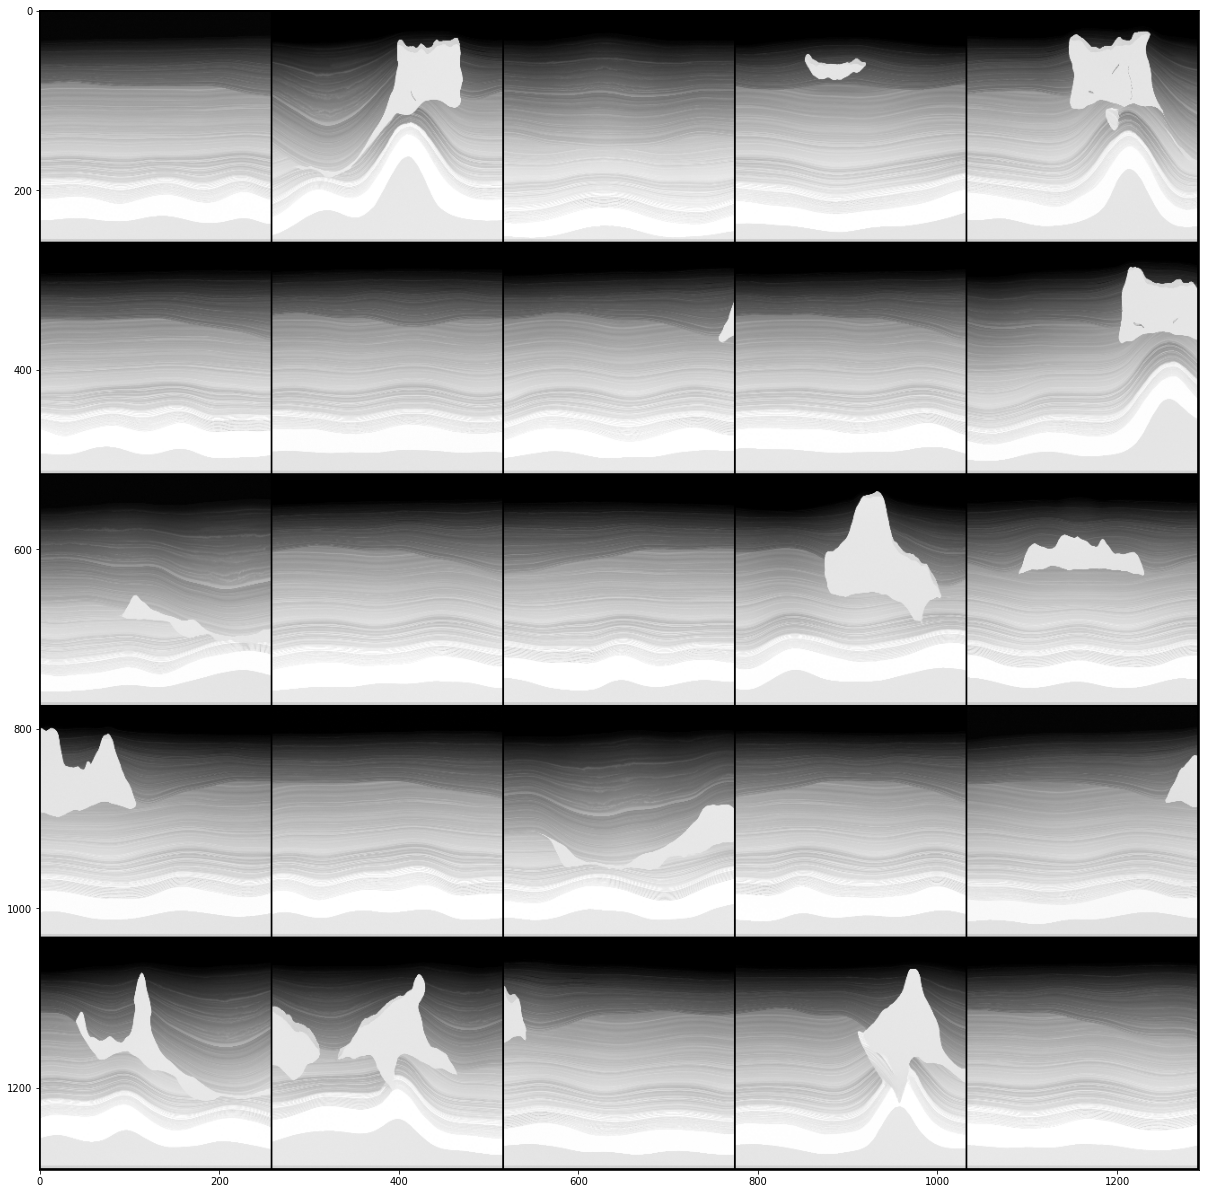

In [16]:
grid_img = torchvision.utils.make_grid(sample, nrow=5)

dpi = matplotlib.rcParams['figure.dpi']

height = width = 6*256
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()